In [ ]:
from google.colab import drive       ## Mounting Drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
pip install opencv-python

In [ ]:
ls '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool'

'0-199 BB_Label Data.csv'
'200-480 BB_Label Data.csv'
'BB_Label Data.csv'
 bird_bridge.avi
 bird_pred/
 bird_street.avi
 bird_strt/
 Bridge__/
 Bridge___/
 Bridge.mp4
 bridges/
 bridges_rate.avi
 bridge_video.avi
'Copy of Pre-trained_Social_Distancing_Tool.ipynb'
 model_SelfTrain.pt
 mpdl.py
 my_bridges/
 my_ParlimentarySQ/
 my_streets/
 ParlimentarySQ/
 ParlimentarySQ.mp4
 ParlimentarySQ_rate.avi
 pred_bridge/
 pred_Street/
 Pre-trained_Social_Distancing_Tool.ipynb
 __pycache__/
'Social_Distancing_Tool final12.ipynb'
 Social_Distancing_Tool_Final_Backbone.ipynb
'Social Distancing Tool.ipynb'
 Street__/
 Street___/
 street.mp4
 streets/
 streets_rate.avi
 Street_video.avi


In [ ]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm



import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

In [ ]:
#Function to extract frames
def extractFrames(pathIn, pathOut):
   #directory path, where my video images will be stored
   os.mkdir(pathOut)
   #Capture video from video file
   cap = cv2.VideoCapture(pathIn)
#Counter Variable
   count = 0
   while (cap.isOpened()):
     # Capture frame-by-frame
     ret, frame = cap.read()
     if ret == True:
       # save frame as JPEG file
       cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), frame)
       count += 1
     else:
       break
    # When everything done, release the capture
   cap.release()
   cv2.destroyAllWindows()

In [ ]:
extractFrames('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Bridge.mp4',
              '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Bridge__')

In [ ]:
extractFrames('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/street.mp4',
              '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Street__')

In [ ]:
Labels_BB= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/BB_Label Data.csv')

In [ ]:
##frames = [Labels_BB_1,Labels_BB_2]

##Labels_BB = pd.concat(frames)

In [ ]:
Labels_BB_imp = Labels_BB[['#filename','region_id','region_shape_attributes']]

In [ ]:
len(Labels_BB_imp)

1747

In [ ]:
from PIL import Image
import glob
Bridge_frames = []
for filename in glob.glob('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Bridge__/*.jpg'):
    im=Image.open(filename)
    Bridge_frames.append(im)

In [ ]:
len(Bridge_frames)

480

In [ ]:
re_size = [cv2.resize(np.float32(img),(600,600), interpolation=cv2.INTER_LINEAR) for img in Bridge_frames] 

In [ ]:
len(re_size)


480

In [ ]:
import pandas as pd
import ast

In [ ]:
eval_dict = []
for i in Labels_BB_imp['region_shape_attributes']:
  eval_dict.append(ast.literal_eval(i))

In [ ]:
eval_dict[1]

{'height': 172, 'name': 'rect', 'width': 52, 'x': 311, 'y': 145}

In [ ]:
new_table = pd.DataFrame(columns = ['filename','class_id'])

In [ ]:
new_table['filename'] = Labels_BB_imp['#filename']


In [ ]:
new_table['class_id'] = Labels_BB_imp['region_id']

In [ ]:
for i in range(0,len(eval_dict)):
  split_table = pd.DataFrame(eval_dict)

In [ ]:
split_table.head(5)

,name,x,y,width,height
0,rect,72,393,52,180
1,rect,311,145,52,172
2,rect,273,28,33,129
3,rect,343,20,31,123
4,rect,75,389,46,177


In [ ]:
new_table['x'] = split_table['x']
new_table['y'] = split_table['y']
new_table['width'] = split_table['width']
new_table['height'] = split_table['height']

In [ ]:
new_table['xmin'] = new_table.apply(lambda row: row.x - 
                                  (row.width/2), axis = 1)
new_table['ymin'] = new_table.apply(lambda row: row.y - 
                                  (row.height/2), axis = 1)
new_table['xmax'] = new_table.apply(lambda row: row.x + 
                                  (row.width/2), axis = 1)
new_table['ymax'] = new_table.apply(lambda row: row.y + 
                                  (row.height/2), axis = 1)

In [ ]:
same_calss = new_table

In [ ]:
same_calss['class_id'].unique()

array([0, 1, 2, 3, 4, 5])

In [ ]:
Row_list =[] 
  
# Iterate over each row 
for index, rows in same_calss.iterrows(): 
    # Create list for the current row 
    my_list =[rows.xmin, rows.ymin, rows.xmax, rows.ymax] 
      
    # append the list to the final list 
    Row_list.append(my_list) 

In [ ]:
Row_list[1]

[285.0, 59.0, 337.0, 231.0]

In [ ]:
same_calss['x1_y1_x2_y2'] = Row_list

In [ ]:
bb_combined = same_calss

In [ ]:
bb_combined.head()

,filename,class_id,x,y,width,height,xmin,ymin,xmax,ymax,x1_y1_x2_y2
0,resize0.jpg,0,72,393,52,180,46.0,303.0,98.0,483.0,"[46.0, 303.0, 98.0, 483.0]"
1,resize0.jpg,1,311,145,52,172,285.0,59.0,337.0,231.0,"[285.0, 59.0, 337.0, 231.0]"
2,resize0.jpg,2,273,28,33,129,256.5,-36.5,289.5,92.5,"[256.5, -36.5, 289.5, 92.5]"
3,resize0.jpg,3,343,20,31,123,327.5,-41.5,358.5,81.5,"[327.5, -41.5, 358.5, 81.5]"
4,resize1.jpg,0,75,389,46,177,52.0,300.5,98.0,477.5,"[52.0, 300.5, 98.0, 477.5]"


In [ ]:
columns = ['x','y','width','height','xmin','ymin','xmax','ymax']
bb_combined = bb_combined.drop(columns,axis=1)

In [ ]:
new_same_calss = bb_combined.groupby('filename',as_index=False).agg(lambda x: list(x))

In [ ]:
new_same_calss.x1_y1_x2_y2[1]

[[52.0, 300.5, 98.0, 477.5],
 [286.0, 71.5, 336.0, 236.5],
 [257.0, -41.5, 289.0, 93.5],
 [331.0, -41.0, 357.0, 81.0]]

In [ ]:
new_same_calss.columns

Index(['filename', 'class_id', 'x1_y1_x2_y2'], dtype='object')

In [ ]:
new_same_calss.head()

,filename,class_id,x1_y1_x2_y2
0,resize0.jpg,"[0, 1, 2, 3]","[[46.0, 303.0, 98.0, 483.0], [285.0, 59.0, 337..."
1,resize1.jpg,"[0, 1, 2, 3]","[[52.0, 300.5, 98.0, 477.5], [286.0, 71.5, 336..."
2,resize10.jpg,"[0, 1, 2, 3]","[[65.5, 263.5, 124.5, 450.5], [283.5, 89.0, 32..."
3,resize100.jpg,"[0, 1, 2, 3, 4]","[[267.5, 87.5, 300.5, 232.5], [99.0, 133.5, 14..."
4,resize101.jpg,"[0, 1, 2, 3, 4]","[[274.5, 89.0, 305.5, 231.0], [96.5, 138.5, 14..."


In [ ]:
tensor_class_id = []
for i in new_same_calss.class_id:
  x = torch.LongTensor(i)
  tensor_class_id.append(x)

In [ ]:
tensor_x1_y1_x2_y2 = []
for i in new_same_calss.x1_y1_x2_y2:
  x = torch.Tensor(i)
  tensor_x1_y1_x2_y2.append(x)

In [ ]:
tensor_x1_y1_x2_y2[1]

tensor([[ 52.0000, 300.5000,  98.0000, 477.5000],
        [286.0000,  71.5000, 336.0000, 236.5000],
        [257.0000, -41.5000, 289.0000,  93.5000],
        [331.0000, -41.0000, 357.0000,  81.0000]])

In [ ]:
tensor_class_id[1]

tensor([0, 1, 2, 3])

In [ ]:
dict_boxes_labels = []
for i in range(0,len(new_same_calss)):
    dict_boxes_labels.append({'boxes':tensor_x1_y1_x2_y2[i],'labels':tensor_class_id[i]})

In [ ]:
len(dict_boxes_labels)

480

In [ ]:
bb_lables_dict_table = new_same_calss

In [ ]:
bb_lables_dict_table['dict_boxes_labels'] = dict_boxes_labels

In [ ]:
bb_lables_dict_table.columns

Index(['filename', 'class_id', 'x1_y1_x2_y2', 'dict_boxes_labels'], dtype='object')

In [ ]:
import re

In [ ]:
final_data = bb_lables_dict_table

In [ ]:
image_array = []
for i in range(0,len(re_size)):
   number = re.findall('\d+',bb_lables_dict_table.filename[i])
   image_array.append(re_size[int(number[0])])  

In [ ]:
final_data['image_array'] = image_array

In [ ]:
len(final_data)

480

In [ ]:
final_data.head()

,filename,class_id,x1_y1_x2_y2,dict_boxes_labels,image_array
0,resize0.jpg,"[0, 1, 2, 3]","[[46.0, 303.0, 98.0, 483.0], [285.0, 59.0, 337...","{'boxes': [[tensor(46.), tensor(303.), tensor(...","[[[201.99998, 206.99998, 203.0], [201.99998, 2..."
1,resize1.jpg,"[0, 1, 2, 3]","[[52.0, 300.5, 98.0, 477.5], [286.0, 71.5, 336...","{'boxes': [[tensor(52.), tensor(300.5000), ten...","[[[201.99998, 206.99998, 203.0], [201.99998, 2..."
2,resize10.jpg,"[0, 1, 2, 3]","[[65.5, 263.5, 124.5, 450.5], [283.5, 89.0, 32...","{'boxes': [[tensor(65.5000), tensor(263.5000),...","[[[201.99998, 206.99998, 203.0], [201.99998, 2..."
3,resize100.jpg,"[0, 1, 2, 3, 4]","[[267.5, 87.5, 300.5, 232.5], [99.0, 133.5, 14...","{'boxes': [[tensor(267.5000), tensor(87.5000),...","[[[203.0, 208.99998, 206.99998], [203.0, 208.9..."
4,resize101.jpg,"[0, 1, 2, 3, 4]","[[274.5, 89.0, 305.5, 231.0], [96.5, 138.5, 14...","{'boxes': [[tensor(274.5000), tensor(89.), ten...","[[[203.0, 208.99998, 206.99998], [203.0, 208.9..."


In [ ]:
final_data['dict_boxes_labels'][150]

{'boxes': tensor([[365.5000, -32.0000, 384.5000,  50.0000],
         [348.0000,  -7.0000, 376.0000, 107.0000],
         [150.0000,  37.0000, 190.0000, 193.0000],
         [417.0000, -20.0000, 441.0000,  22.0000]]),
 'labels': tensor([0, 1, 2, 3])}

In [ ]:
tensor_image_array = []
for i in final_data.image_array:
  x = torch.FloatTensor(i)
  y = torch.reshape(x,(3,600,600))
  tensor_image_array.append(y)

In [ ]:
imgs = tensor_image_array
targets = final_data['dict_boxes_labels']

In [ ]:
Input_Data=[]
for i in range(0,len(imgs)):
  Input_Data.append((imgs[i],targets[i]))

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data= train_test_split(Input_Data, test_size=0.05)

In [ ]:
len(train_data)

456

In [ ]:
x,y = train_data[0]

In [ ]:
y

{'boxes': tensor([[384.0000, -50.0000, 410.0000,  56.0000],
         [403.5000, -25.0000, 424.5000,  27.0000],
         [-25.0000, 309.0000,  25.0000, 461.0000]]),
 'labels': tensor([0, 1, 2])}

In [ ]:
sizes = []
for i in tensor_image_array:
  x = i.shape
  sizes.append(x)

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool')

from mpdl import set_seed
from mpdl import train_network, Flatten, View, weight_reset

In [ ]:
def collate_fn(batch):
    """
    batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
    The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. So we will use this function to convert the 
    batch of data into the form we want, and then give it to the Dataloader to use
    """
    imgs = []
    labels = []
    for img, label in batch:
        imgs.append(img)
        labels.append(label)
    return imgs, labels

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 6

n_filters = 32

In [ ]:
backbone = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1),    
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(), 
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(), 
    nn.MaxPool2d((2,2),stride=(3,4)), 
    nn.Conv2d(n_filters, 2*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(),                     
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(2*n_filters), 
    nn.LeakyReLU(),
    nn.MaxPool2d((2,2),stride=(2,2)), 
    nn.Conv2d(2*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(4*n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(4*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(4*n_filters),
    nn.LeakyReLU(),
    nn.MaxPool2d((2,2),stride=(2,2)), 
    nn.Conv2d(4*n_filters, 8*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(8*n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(8*n_filters, 8*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(8*n_filters),
    nn.LeakyReLU(),
    nn.MaxPool2d((2,2),stride=(2,2)),
    nn.Conv2d(8*n_filters, 16*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(16*n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(16*n_filters, 16*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(16*n_filters),
    nn.LeakyReLU(), 
)

backbone.out_channels = n_filters*16

In [ ]:
model2 = FasterRCNN(backbone, num_classes=6, 
                #image_mean = [0.5], image_std = [0.229],
                #if they were color images
                 image_mean = (0.5, 0.5, 0.5), image_std = (0.229, 0.229, 0.229)
                  )

In [ ]:
model2 = model2.train()
model2.to(device)
optimizer = torch.optim.AdamW(model2.parameters())

loss_hist = []

for epoch in tqdm(range(10), desc="Epoch", disable=False):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=False):
        #Move the batch to the device we are using. 
        inputs = [i.to(device) for i in inputs]
#         labels = labels.to(device)
        labels = [dict([(k,v.to(device)) for k,v in d.items()]) for d in labels]

        optimizer.zero_grad()

        losses = model2(inputs, labels)
        # Compute loss.
        loss = 0
        for partial_loss in losses.values():
            loss += partial_loss

        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
        
        loss_hist.append(loss.item())

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/model_SelfTrain.pt'
torch.save(model2.state_dict(), PATH)

In [ ]:
model2 = model2.eval()
model2= model2.to(device)

In [ ]:
import matplotlib.patches as patches
def plotDetection(ax, abs_pos, label=None):
    x1, y1, x2, y2 = abs_pos
    
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    if label is not None:
        plt.text(x1+0.5, y1, label, color='black', bbox=dict(facecolor='white', edgecolor='white', pad=1.0))
    
    return 

In [ ]:
def showPreds(img, pred, iou_max_overlap=0.5, min_score=0.05, label_names=None):
    """
    img: the original image object detection was performed on
    pred: the output dictionary from FasterRCNN for evaluation on img
    iou_max_overlap: the iou threshold at which non-maximum suppression will be performed
    min_score: the minimum RPN network score to consider an object
    """
    fig,ax = plt.subplots(1)
    img = img.cpu().numpy()
    if img.shape[0] == 1:
        ax.imshow(img[0,:])
    else:
        ax.imshow(np.moveaxis(img, 0, 2))
    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()
    
    selected = nms(boxes, scores, iou_max_overlap).cpu().numpy()
    
    for i in selected:
        if scores[i].item() > min_score:
            if label_names is None:
                label = str(labels[i].item())
            else:
                label = label_names[labels[i].item()]
            plotDetection(ax, boxes[i].cpu().numpy(), label=label)
    
    plt.show()

In [ ]:
x,y = test_data[0]

In [ ]:

    ## as pytorch models only accept tensors and shape inspecific way converting to tensors and chnaging shape t0 (3,720,1280)
with torch.no_grad():                                            
  pred = model2([x])

In [ ]:
pred[0]                         #coordinates, labels, scores of the prediction of an image
                                #there are multiple predictions
                                #score is also very less

{'boxes': tensor([[287.6707,  66.6648, 334.2833, 225.8144],
         [ 39.0332, 294.9340, 101.8755, 526.0132],
         [291.0624,  51.9614, 311.6388, 261.2302],
         [299.5331,  53.5878, 319.3089, 235.4733],
         [ 60.0336, 266.5402, 119.5310, 503.6440],
         [284.4784,  72.6872, 305.5305, 269.9460],
         [308.8372,   3.0053, 330.1629, 227.5575],
         [281.9531, 111.2188, 322.9257, 254.1202],
         [303.0660,  60.1467, 343.6287, 203.0968],
         [ 18.6436, 354.0460,  78.7637, 552.7528],
         [313.7089,   4.3723, 359.1384, 153.2505],
         [  0.0000, 379.8773,  35.5270, 580.6762],
         [273.1059, 102.2881, 308.3529, 244.7855],
         [314.5067,  56.6704, 335.0117, 201.2442],
         [ 70.6061, 209.1265, 122.5446, 410.2245],
         [  0.0000, 302.0448,  66.4618, 515.7721],
         [ 37.5198, 295.1083, 103.5556, 524.8768],
         [102.3974, 160.0752, 123.2486, 444.9744],
         [  0.0000, 395.2138,  16.4007, 558.7050],
         [331.7133,   

In [ ]:
from torchvision.ops import nms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


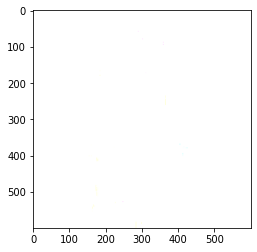

In [ ]:
showPreds(x, pred[0], iou_max_overlap=0.5, min_score=0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


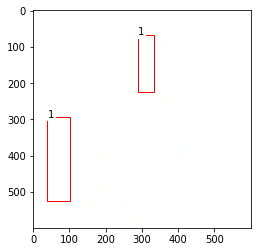

In [ ]:
showPreds(x, pred[0], iou_max_overlap=0.5, min_score=0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


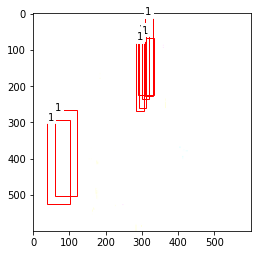

In [ ]:
showPreds(x, pred[0], iou_max_overlap=0.5, min_score=0.2)

In [ ]:
model2.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=(0.5, 0.5, 0.5), std=(0.229, 0.229, 0.229))
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(3, 4), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11):